# **Import Libraries**

In [1]:
# Import
import pandas as pd
import gensim
import json
import string
import nltk

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import re, string
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Dataset 1: STS Benchmark**

## Step 1: Read JSONL File
Read JSON file and extract all sentences and scores.

In [ ]:
sentence_pairs = []
scores = []

# Open the JSONL file
with open('train.jsonl', 'r') as f:
    for line in f:
        # Parse each line as JSON
        data = json.loads(line)

        # Extract sentence1 and sentence2
        sentence1 = data.get('sentence1', None)
        sentence2 = data.get('sentence2', None)
        score = data.get('score', None)  # Ground truth similarity score

        if sentence1 and sentence2:
            sentence_pairs.append((sentence1, sentence2))
            # Normalize the score by dividing by 5 (original scale: 0-5, normalized: 0-1)
            scores.append(score / 5.0)  # Normalize the score to [0, 1]
        else:
            print("No sentence1 or sentence2 found in the JSON object.")

all_sentences = [sentence for pair in sentence_pairs for sentence in pair]
print(all_sentences)
print(scores)

['A plane is taking off.', 'An air plane is taking off.', 'A man is playing a large flute.', 'A man is playing a flute.', 'A man is spreading shreded cheese on a pizza.', 'A man is spreading shredded cheese on an uncooked pizza.', 'Three men are playing chess.', 'Two men are playing chess.', 'A man is playing the cello.', 'A man seated is playing the cello.', 'Some men are fighting.', 'Two men are fighting.', 'A man is smoking.', 'A man is skating.', 'The man is playing the piano.', 'The man is playing the guitar.', 'A man is playing on a guitar and singing.', 'A woman is playing an acoustic guitar and singing.', 'A person is throwing a cat on to the ceiling.', 'A person throws a cat on the ceiling.', 'The man hit the other man with a stick.', 'The man spanked the other man with a stick.', 'A woman picks up and holds a baby kangaroo.', 'A woman picks up and holds a baby kangaroo in her arms.', 'A man is playing a flute.', 'A man is playing a bamboo flute.', 'A person is folding a piece

## Step 2: Tokenise the Sentences

In [ ]:
# Tokenize and remove punctuation
tokenized_sentences = [
    [word for word in word_tokenize(sentence.lower()) if word not in string.punctuation]
    for sentence in all_sentences
]

print(tokenized_sentences)

[['a', 'plane', 'is', 'taking', 'off'], ['an', 'air', 'plane', 'is', 'taking', 'off'], ['a', 'man', 'is', 'playing', 'a', 'large', 'flute'], ['a', 'man', 'is', 'playing', 'a', 'flute'], ['a', 'man', 'is', 'spreading', 'shreded', 'cheese', 'on', 'a', 'pizza'], ['a', 'man', 'is', 'spreading', 'shredded', 'cheese', 'on', 'an', 'uncooked', 'pizza'], ['three', 'men', 'are', 'playing', 'chess'], ['two', 'men', 'are', 'playing', 'chess'], ['a', 'man', 'is', 'playing', 'the', 'cello'], ['a', 'man', 'seated', 'is', 'playing', 'the', 'cello'], ['some', 'men', 'are', 'fighting'], ['two', 'men', 'are', 'fighting'], ['a', 'man', 'is', 'smoking'], ['a', 'man', 'is', 'skating'], ['the', 'man', 'is', 'playing', 'the', 'piano'], ['the', 'man', 'is', 'playing', 'the', 'guitar'], ['a', 'man', 'is', 'playing', 'on', 'a', 'guitar', 'and', 'singing'], ['a', 'woman', 'is', 'playing', 'an', 'acoustic', 'guitar', 'and', 'singing'], ['a', 'person', 'is', 'throwing', 'a', 'cat', 'on', 'to', 'the', 'ceiling'], ['

In [ ]:
# Function to compute the average Word2Vec embedding for a sentence
def get_sentence_embedding(sentence, model):
    words = [word for word in word_tokenize(sentence.lower()) if word in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

## Step 3: Train

In [ ]:
def sentence2vec_train(vector_size_val, lr_val, sg_val, epochs_val, parameter_tuning):
  # Train Word2Vec model
  model = Word2Vec(sentences=tokenized_sentences, vector_size=vector_size_val, window=5, min_count=1, workers=4, epochs = epochs_val, sg=sg_val, alpha=lr_val)

  # Save the model for future use
  model_name = f"word2vec_epoch{epochs_val}.model"
  model.save(model_name)
  print(f"Model saved as {model_name}")

  # After training the model, compute the cosine similarity for both sentences
  # Compare cosine similarity between each sentence pair
  cosine_similarities = []

  for i, (sentence1, sentence2) in enumerate(sentence_pairs):
      # Get sentence embeddings
      sentence1_embedding = get_sentence_embedding(sentence1, model)
      sentence2_embedding = get_sentence_embedding(sentence2, model)

      # Compute cosine similarity
      similarity = cosine_similarity([sentence1_embedding], [sentence2_embedding])[0][0]
      cosine_similarities.append(similarity)

      # Compare with ground truth score
      ground_truth_score = scores[i]
      # print(f"Sentence 1: {sentence1}")
      #print(f"Sentence 2: {sentence2}")
      #print(f"Cosine Similarity: {similarity}")
      #print(f"Ground Truth Similarity: {ground_truth_score}")
      #print()

  # Calculate Spearman Correlation
  # correlation, p_value = spearmanr(cosine_similarities, scores)
  # print(f"[TRAIN] Spearman Correlation between predicted and ground truth scores: {correlation}")

  # Calculate classification metrics
  f1, precision, recall, accuracy = calculate_classification_metrics(cosine_similarities, scores)
  print(f"[TRAIN] F1 Score: {f1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")

  if parameter_tuning:

    # Calculate Mean Squared Error
    mse = mean_squared_error(cosine_similarities, scores)
    print(f"Mean Squared Error between predicted and ground truth scores: {mse}")
    mse_values_train.append(mse)

  return model

In [ ]:
def calculate_classification_metrics(predicted_scores, true_scores, threshold=0.5):
    # Convert scores to binary predictions based on threshold
    predictions = [1 if score >= threshold else 0 for score in predicted_scores]
    true_labels = [1 if score >= threshold else 0 for score in true_scores]

    # Calculate metrics
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)  # Add accuracy calculation

    return f1, precision, recall, accuracy

def plot_mse(value_type, values, mse_values):
    plt.figure(figsize=(10, 6))
    plt.plot(values, mse_values, marker='o')
    plt.title(f'Mean Squared Error Over {value_type}')
    plt.xlabel(f'{value_type}')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid()
    plt.xticks(values)
    plt.show()

In [ ]:
# Train the model
model = sentence2vec_train(vector_size_val=100, lr_val=0.025, sg_val=0, epochs_val=5, parameter_tuning = False) #default

Model saved as word2vec_epoch5.model
[TRAIN] F1 Score: 0.7462654018100534, Precision: 0.5952339537310837, Recall: 1.0, Accuracy: 0.5952339537310837


## Step 4: Validation

After training, evaluate the model's performance on the validation set.

In [ ]:
val_sentence_pairs = []
val_scores = []

# Open the JSONL file
with open('validation.jsonl', 'r') as f:
    for line in f:
        # Parse each line as JSON
        data = json.loads(line)

        # Extract sentence1 and sentence2
        sentence1 = data.get('sentence1', None)
        sentence2 = data.get('sentence2', None)
        val_score = data.get('score', None)  # Ground truth similarity score

        if sentence1 and sentence2:
            val_sentence_pairs.append((sentence1, sentence2))
            # Normalize the score by dividing by 5 (original scale: 0-5, normalized: 0-1)
            val_scores.append(val_score / 5.0)  # Normalize the score to [0, 1]
        else:
            print("No sentence1 or sentence2 found in the JSON object.")

test_all_sentences = [sentence for pair in val_sentence_pairs for sentence in pair]
#print(test_all_sentences)
#print(val_scores)

In [ ]:
def sentence2vec_val(model, parameter_tuning):
  # Compare cosine similarity between each sentence pair
  val_cosine_similarities = []

  for i, (val_sentence1, val_sentence2) in enumerate(val_sentence_pairs):
      # Get sentence embeddings
      val_sentence1_embedding = get_sentence_embedding(val_sentence1, model)
      val_sentence2_embedding = get_sentence_embedding(val_sentence2, model)

      # Compute cosine similarity
      similarity = cosine_similarity([val_sentence1_embedding], [val_sentence2_embedding])[0][0]
      val_cosine_similarities.append(similarity)

      # Compare with ground truth score
      ground_truth_score = val_scores[i]
      #print(f"Sentence 1: {sentence1}")
      #print(f"Sentence 2: {sentence2}")
      #print(f"Cosine Similarity: {similarity}")
      #print(f"Ground Truth Similarity: {ground_truth_score}")
      #print()

  # Calculate Spearman Correlation
  #correlation, p_value = spearmanr(cosine_similarities, val_scores)
  #print(f"[TEST] Spearman Correlation between predicted and ground truth scores: {correlation}")

  f1, precision, recall, accuracy = calculate_classification_metrics(val_cosine_similarities, val_scores)
  print(f"[VALIDATION] F1 Score: {f1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")

  if parameter_tuning:
    # Calculate Mean Squared Error
    mse = mean_squared_error(val_cosine_similarities, val_scores)
    print(f"Mean Squared Error between predicted and ground truth scores: {mse}")
    mse_values_val.append(mse)

  return model

In [ ]:
sentence2vec_val(model, False)

[VALIDATION] F1 Score: 0.6708019494904741, Precision: 0.5046666666666667, Recall: 1.0, Accuracy: 0.5046666666666667


## Step 5: Hyperparameter Tuning


Epoch Value:  10
Model saved as word2vec_epoch10.model
[TRAIN] F1 Score: 0.7462654018100534, Precision: 0.5952339537310837, Recall: 1.0, Accuracy: 0.5952339537310837
Mean Squared Error between predicted and ground truth scores: 0.2802092338161902
[VALIDATION] F1 Score: 0.6708019494904741, Precision: 0.5046666666666667, Recall: 1.0, Accuracy: 0.5046666666666667
Mean Squared Error between predicted and ground truth scores: 0.33907891386406624

Epoch Value:  20
Model saved as word2vec_epoch20.model
[TRAIN] F1 Score: 0.7465880554645704, Precision: 0.5959560746034512, Recall: 0.9991233196960841, Accuracy: 0.5962776134979997
Mean Squared Error between predicted and ground truth scores: 0.2371751063161095
[VALIDATION] F1 Score: 0.6702222222222223, Precision: 0.5050234427327528, Recall: 0.9960369881109643, Accuracy: 0.5053333333333333
Mean Squared Error between predicted and ground truth scores: 0.2768529332581699

Epoch Value:  30
Model saved as word2vec_epoch30.model
[TRAIN] F1 Score: 0.7501

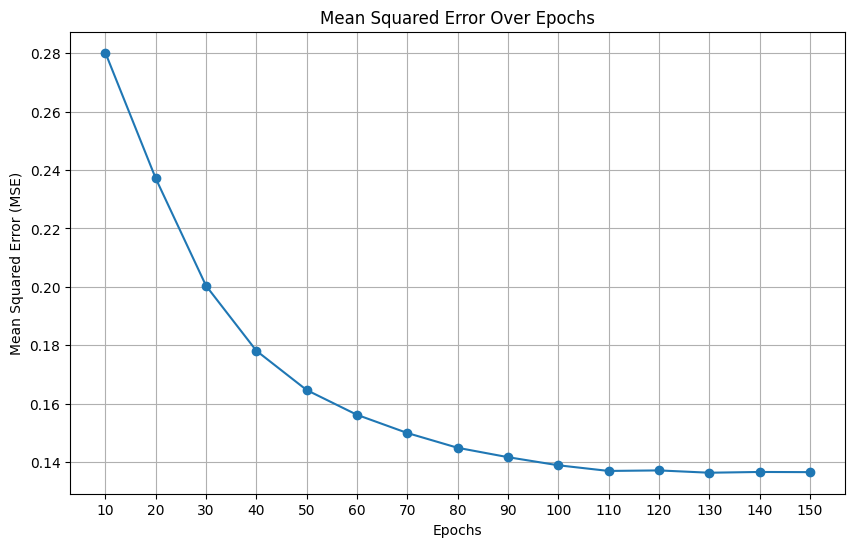

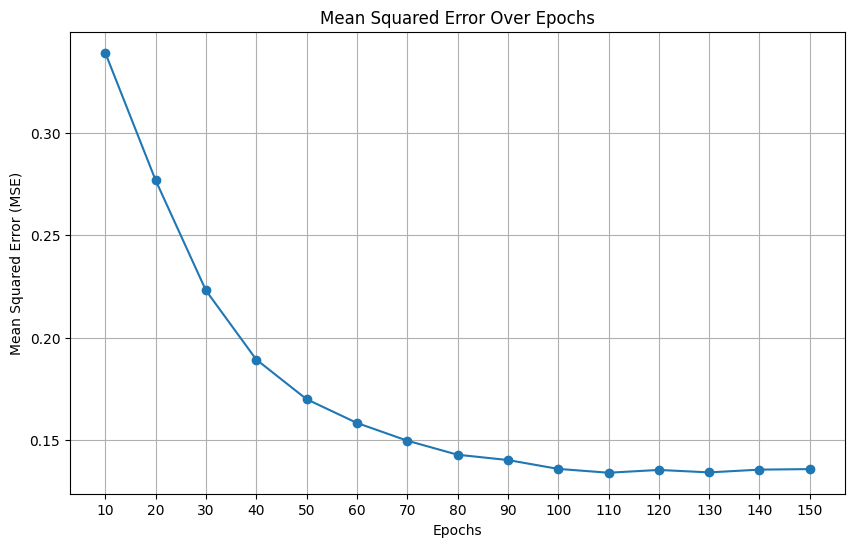

In [ ]:
# Changing Epoch Values (CBOW)
mse_values_train = []
mse_values_val = []
epoch_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
for epochs in epoch_values:
  print("Epoch Value: ", epochs)
  model = sentence2vec_train(100, 0.025, 0, epochs, True)
  sentence2vec_val(model, parameter_tuning = True)
  print()
plot_mse("Epochs", epoch_values, mse_values_train)
plot_mse("Epochs", epoch_values, mse_values_val)

Number of Epochs That Will Be Used (CBOW) = 110.



Epoch Value:  10
Model saved as word2vec_epoch10.model
[TRAIN] F1 Score: 0.7462654018100534, Precision: 0.5952339537310837, Recall: 1.0, Accuracy: 0.5952339537310837
Mean Squared Error between predicted and ground truth scores: 0.25271581697557866
[VALIDATION] F1 Score: 0.6708019494904741, Precision: 0.5046666666666667, Recall: 1.0, Accuracy: 0.5046666666666667
Mean Squared Error between predicted and ground truth scores: 0.30089514508173626

Epoch Value:  20
Model saved as word2vec_epoch20.model
[TRAIN] F1 Score: 0.7468616963213623, Precision: 0.5960968809897195, Recall: 0.9997077732320281, Accuracy: 0.5966255000869717
Mean Squared Error between predicted and ground truth scores: 0.20810750807499728
[VALIDATION] F1 Score: 0.6711051930758988, Precision: 0.5053475935828877, Recall: 0.9986789960369881, Accuracy: 0.506
Mean Squared Error between predicted and ground truth scores: 0.2364691558513034

Epoch Value:  30
Model saved as word2vec_epoch30.model
[TRAIN] F1 Score: 0.748250218722659

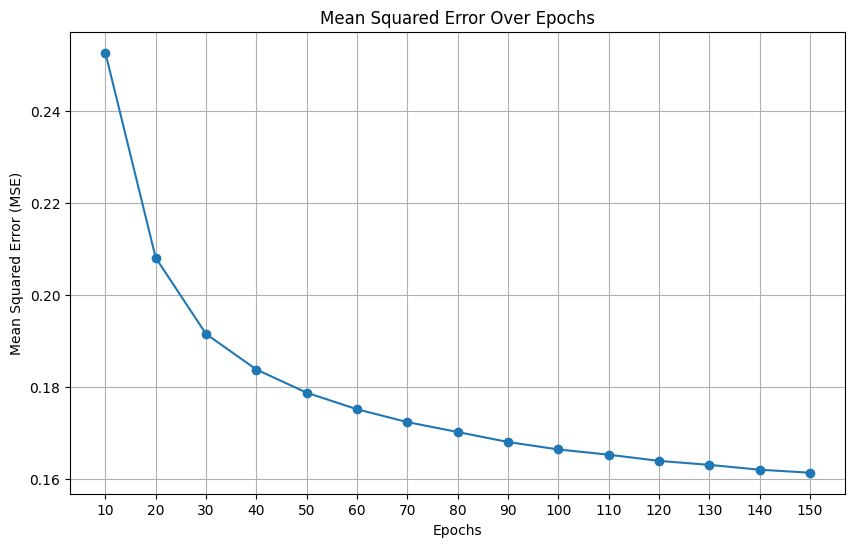

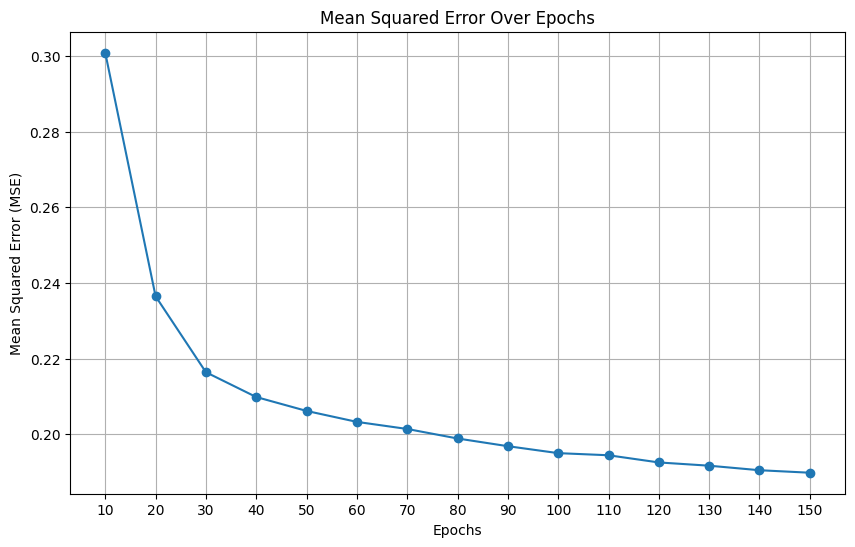

In [ ]:
# Changing Epoch Values (Skip-Gram)
mse_values_train = []
mse_values_val = []
epoch_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
for epochs in epoch_values:
  print("Epoch Value: ", epochs)
  model = sentence2vec_train(100, 0.025, 1, epochs, True)
  sentence2vec_val(model, parameter_tuning = True)
  print()
plot_mse("Epochs", epoch_values, mse_values_train)
plot_mse("Epochs", epoch_values, mse_values_val)

In [ ]:
epoch_values = [110]

In [ ]:
#Skip-gram VS CBOW

#CBOW
model = sentence2vec_train(100, 0.025, 0, epoch_values[0], True)
sentence2vec_val(model, True)

#Skip-Gram
model = sentence2vec_train(100, 0.025, 1, epoch_values[0], True)
sentence2vec_val(model, True)


Model saved as word2vec_epoch110.model
[TRAIN] F1 Score: 0.7588168373151308, Precision: 0.621274217585693, Recall: 0.9745762711864406, Accuracy: 0.6312402156896851
Mean Squared Error between predicted and ground truth scores: 0.1377437524083473
[VALIDATION] F1 Score: 0.6914839367669556, Precision: 0.5631229235880398, Recall: 0.8956406869220608, Accuracy: 0.5966666666666667
Mean Squared Error between predicted and ground truth scores: 0.13494517027912756
Model saved as word2vec_epoch110.model
[TRAIN] F1 Score: 0.751207729468599, Precision: 0.6016531832571228, Recall: 0.9997077732320281, Accuracy: 0.6058444946947296
Mean Squared Error between predicted and ground truth scores: 0.16520961610119328
[VALIDATION] F1 Score: 0.6717014660151044, Precision: 0.5060240963855421, Recall: 0.9986789960369881, Accuracy: 0.5073333333333333
Mean Squared Error between predicted and ground truth scores: 0.19380301875491246


CBOW has overall lower MSE(?)

Will continue using CBOW with 110 epochs.



In [ ]:
# Learning Rate: Default learning rate for the Word2Vec implementation in Gensim is 0.025

lr_values = [0.1, 0.09, 0.08, 0.07, 0.06, 0.050, 0.040, 0.030, 0.020, 0.010]

mse_values_train = []
mse_values_val = []

for lr in lr_values:
  print("Learning Rate Value: ", lr)
  model = sentence2vec_train(100, lr, 0, epoch_values[0], True)
  sentence2vec_val(model, parameter_tuning = True)
  print()

Learning Rate Value:  0.1
Model saved as word2vec_epoch110.model
[TRAIN] F1 Score: 0.7717566016073478, Precision: 0.635590015128593, Recall: 0.9821741671537113, Accuracy: 0.6542007305618368
Mean Squared Error between predicted and ground truth scores: 0.10768133795828494
[VALIDATION] F1 Score: 0.7144420131291028, Precision: 0.6097105508870215, Recall: 0.8626155878467635, Accuracy: 0.652
Mean Squared Error between predicted and ground truth scores: 0.10113531195196672

Learning Rate Value:  0.09
Model saved as word2vec_epoch110.model
[TRAIN] F1 Score: 0.7709906199954244, Precision: 0.6334586466165414, Recall: 0.9848042080654588, Accuracy: 0.6517655244390329
Mean Squared Error between predicted and ground truth scores: 0.1108475212042608
[VALIDATION] F1 Score: 0.7079261672095548, Precision: 0.6009216589861751, Recall: 0.8612945838837517, Accuracy: 0.6413333333333333
Mean Squared Error between predicted and ground truth scores: 0.10506876259261343

Learning Rate Value:  0.08
Model saved a

KeyboardInterrupt: 

In [ ]:
print(mse_values_train)
print(mse_values_val)

In [ ]:
plot_mse("Learning Rate", lr_values, mse_values_train)
plot_mse("Learning Rate", lr_values, mse_values_val)

In [ ]:
# Vector Size
vector_sizes = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

mse_values_train = []
mse_values_val = []

for vector_size in vector_sizes:
  print("Vector Size: ", vector_size)
  model = sentence2vec_train(vector_size, 0.025, 1, epoch_values[0], parameter_tuning = True)
  sentence2vec_val(model, parameter_tuning = True)
  print()

Vector Size:  50
Model saved as word2vec_epoch110.model
[TRAIN] F1 Score: 0.7503015681544029, Precision: 0.6004914867474109, Recall: 0.9997077732320281, Accuracy: 0.6039311184553835
Mean Squared Error between predicted and ground truth scores: 0.18312010483785535
[VALIDATION] F1 Score: 0.6702127659574468, Precision: 0.5043362241494329, Recall: 0.9986789960369881, Accuracy: 0.504
Mean Squared Error between predicted and ground truth scores: 0.22482472981797635

Vector Size:  75
Model saved as word2vec_epoch110.model
[TRAIN] F1 Score: 0.7510150334686712, Precision: 0.6013002987172729, Recall: 1.0, Accuracy: 0.6053226648112715
Mean Squared Error between predicted and ground truth scores: 0.1716656098968023
[VALIDATION] F1 Score: 0.670509977827051, Precision: 0.5046728971962616, Recall: 0.9986789960369881, Accuracy: 0.5046666666666667
Mean Squared Error between predicted and ground truth scores: 0.2052389024688752

Vector Size:  100
Model saved as word2vec_epoch110.model
[TRAIN] F1 Score: 

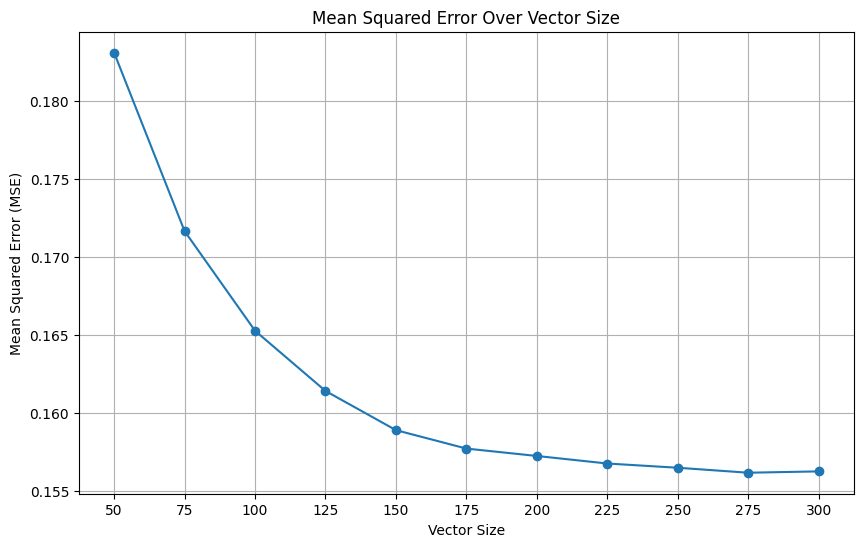

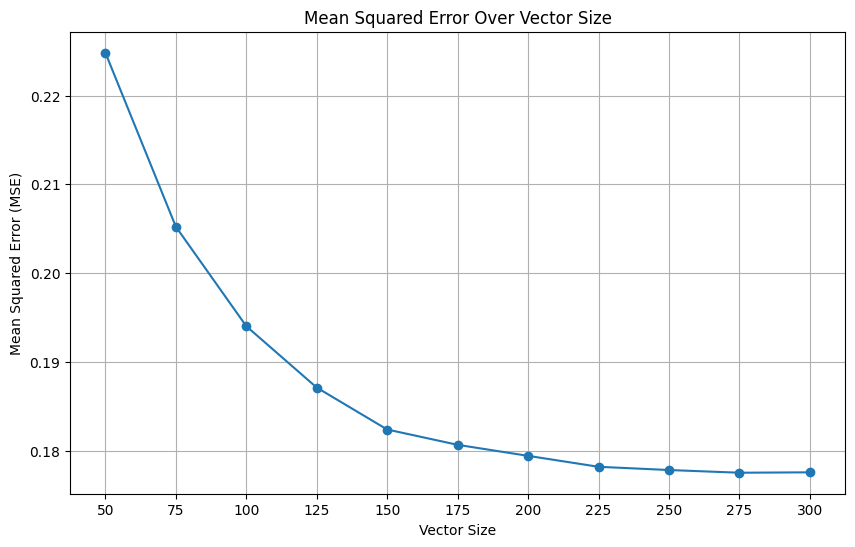

In [ ]:
plot_mse("Vector Size", vector_sizes, mse_values_train)
plot_mse("Vector Size", vector_sizes, mse_values_val)

## Step 6: Test

Epoch Value = 110

Use CBOW.

Learning Rate = 0.1

Vector Size = 225

In [ ]:
test_sentence_pairs = []
test_scores = []

# Open the JSONL file
with open('test.jsonl', 'r') as f:
    for line in f:
        # Parse each line as JSON
        data = json.loads(line)

        # Extract sentence1 and sentence2
        sentence1 = data.get('sentence1', None)
        sentence2 = data.get('sentence2', None)
        score = data.get('score', None)  # Ground truth similarity score

        if sentence1 and sentence2:
            test_sentence_pairs.append((sentence1, sentence2))
            # Normalize the score by dividing by 5 (original scale: 0-5, normalized: 0-1)
            test_scores.append(score / 5.0)  # Normalize the score to [0, 1]
        else:
            print("No sentence1 or sentence2 found in the JSON object.")

test_all_sentences = [sentence for pair in test_sentence_pairs for sentence in pair]
print(test_all_sentences)
print(test_scores)

['A girl is styling her hair.', 'A girl is brushing her hair.', 'A group of men play soccer on the beach.', 'A group of boys are playing soccer on the beach.', "One woman is measuring another woman's ankle.", "A woman measures another woman's ankle.", 'A man is cutting up a cucumber.', 'A man is slicing a cucumber.', 'A man is playing a harp.', 'A man is playing a keyboard.', 'A woman is cutting onions.', 'A woman is cutting tofu.', 'A man is riding an electric bicycle.', 'A man is riding a bicycle.', 'A man is playing the drums.', 'A man is playing the guitar.', 'A man is playing guitar.', 'A lady is playing the guitar.', 'A man is playing a guitar.', 'A man is playing a trumpet.', 'A man is playing a guitar.', 'A man is playing a trumpet.', 'A man is cutting an onion.', 'A man cuts an onion.', 'A man is cycling.', 'A man is talking.', 'A man is slicing open a fish.', 'A man is cutting up a fish.', 'A man is slicing a tomato.', 'A man is slicing a bun.', 'A man is playing a guitar.', 

In [ ]:
def sentence2vec_test(model):
  # Compare cosine similarity between each sentence pair
  test_cosine_similarities = []

  for i, (test_sentence1, test_sentence2) in enumerate(test_sentence_pairs):
      # Get sentence embeddings
      test_sentence1_embedding = get_sentence_embedding(test_sentence1, model)
      test_sentence2_embedding = get_sentence_embedding(test_sentence2, model)

      # Compute cosine similarity
      similarity = cosine_similarity([test_sentence1_embedding], [test_sentence2_embedding])[0][0]
      test_cosine_similarities.append(similarity)

      # Compare with ground truth score
      ground_truth_score = test_scores[i]
      #print(f"Sentence 1: {sentence1}")
      #print(f"Sentence 2: {sentence2}")
      #print(f"Cosine Similarity: {similarity}")
      #print(f"Ground Truth Similarity: {ground_truth_score}")
      #print()

  # Calculate Spearman Correlation
  #correlation, p_value = spearmanr(cosine_similarities, test_scores)
  #print(f"[TEST] Spearman Correlation between predicted and ground truth scores: {correlation}")

  f1, precision, recall, accuracy = calculate_classification_metrics(test_cosine_similarities, test_scores)
  print(f"[TEST] F1 Score: {f1}, Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")

  # Calculate Mean Squared Error
  mse = mean_squared_error(test_cosine_similarities, test_scores)
  print(f"Mean Squared Error between predicted and ground truth scores: {mse}")
  #mse_values_test.append(mse)

In [ ]:
# Run the Model
model = sentence2vec_train(225, 0.025, 1, epoch_values[0], parameter_tuning = True)
sentence2vec_test(model)
print()

Model saved as word2vec_epoch110.model
[TRAIN] F1 Score: 0.7526952695269526, Precision: 0.6035638673253352, Recall: 0.9997077732320281, Accuracy: 0.6089754739954775
Mean Squared Error between predicted and ground truth scores: 0.156795715289243
[TEST] F1 Score: 0.7208216619981326, Precision: 0.5635036496350365, Recall: 1.0, Accuracy: 0.5663524292965917
Mean Squared Error between predicted and ground truth scores: 0.18517964941578274



# **Dataset 2: Text Document Classification Dataset**

## Dataset Information
- Unlabelled data
- Contains 2 columns (Text and Label)
- Text can contain 1 or more sentences.
- Label is 1 through 5.

## Steps Taken

### Step 1: Read CSV File

### Step 2: Text Tokenisation

### Step 3: Data Splitting
- Training Set (train_df): 80%

- Validation Set (val_df): 10%

- Test Set (test_df): 10%

### Step 4: Training the Word2Vec Model
Train a Word2Vec model on the tokenized training set.


### Step 5: Generate Sentence Embeddings
Create sentence embeddings for both the training and validation sets by averaging the word vectors.


### Step 6: Classify Validation Data
Implement a function to classify a sentence based on the nearest neighbor similarity using cosine similarity.


### Step 7: Confusion Matrix + Evaluation Metrics
Generate and visualize a confusion matrix to analyze the model's performance on the validation set.

### Step 8: Hyperparameter Tuning
Analyze the confusion matrix for potential improvements. Consider tuning hyperparameters (e.g., increasing the number of epochs for Word2Vec) or adjusting the classification method.

### Step 9: Testing
Use the same nearest neighbor similarity method to predict labels for the test set and evaluate its performance.

### Step 10: Evaluation Metrics

In [3]:
#Step 1: Read the CSV File

df = pd.read_csv('df_file.csv')
df['Text'] = df['Text'].astype(str)
df['Label'] = df['Label'].astype(str)
df.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [4]:
# Step 2: Tokenise Text in Dataset

def tokenize_text(text):
    # Split the text into sentences
    sentences = sent_tokenize(text)
    # Tokenize each sentence into words
    tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
    return tokenized_sentences

df['Tokenised_Text'] = df['Text'].apply(tokenize_text)
sentences = [sentence for sublist in df['Tokenised_Text'] for sentence in sublist]
df.head()

,Text,Label,Tokenised_Text
0,Budget to set scene for election\n \n Gordon B...,0,"[[budget, to, set, scene, for, election, gordo..."
1,Army chiefs in regiments decision\n \n Militar...,0,"[[army, chiefs, in, regiments, decision, milit..."
2,Howard denies split over ID cards\n \n Michael...,0,"[[howard, denies, split, over, id, cards, mich..."
3,Observers to monitor UK election\n \n Minister...,0,"[[observers, to, monitor, uk, election, minist..."
4,Kilroy names election seat target\n \n Ex-chat...,0,"[[kilroy, names, election, seat, target, ex-ch..."


In [5]:
# Step 3: Split data into train, validation, test
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['Label'])

print("DF_TRAIN:", df_train.shape,"\n")
print("DF_VAL:", df_val.shape, "\n")
print("DF_TEST:", df_test.shape, "\n")

DF_TRAIN: (1780, 3) 

DF_VAL: (222, 3) 

DF_TEST: (223, 3) 



In [9]:
# Step 4: Train the Word2Vec model on the training dataset
model = Word2Vec([tokenized_sentence for sentence_list in df_train['Tokenised_Text'] for tokenized_sentence in sentence_list], vector_size=100, window=5, min_count=1, workers=4, epochs=5, sg=1)

# Save the model if you want to reuse it later
model.save("word2vec.model")

In [10]:
# Step 5: Generate sentence embeddings for validation sets

# Helper function to get sentence vector by averaging word vectors
def get_sentence_vector(model, sentence):
    words = [word for word in sentence if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)  # return zero vector if no words found
    return np.mean([model.wv[word] for word in words], axis=0)

df_train['Sentence_Vector'] = df_train['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))
df_val['Sentence_Vector'] = df_val['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))

In [11]:
# Step 6: Classify Validation Data Using Nearest Neighbor

# Function to classify a sentence based on nearest neighbor similarity
def classify_sentence(sentence_vector, train_vectors, train_labels):
    similarity_scores = cosine_similarity([sentence_vector], train_vectors)[0]
    most_similar_index = np.argmax(similarity_scores)
    return train_labels[most_similar_index]

# Classify validation set
train_vectors = np.vstack(df_train['Sentence_Vector'].values)
train_labels = df_train['Label'].values

df_val['Predicted_Label'] = df_val['Sentence_Vector'].apply(lambda vec: classify_sentence(vec, train_vectors, train_labels))

In [ ]:
# Step 7: Evaluate the Model

# Calculate accuracy
accuracy = accuracy_score(df_val['Label'], df_val['Predicted_Label'])
print(f'Validation Accuracy: {accuracy}')

# Confusion matrix
conf_matrix = confusion_matrix(df_val['Label'], df_val['Predicted_Label'])
print(f'Confusion Matrix:\n{conf_matrix}')

# Detailed classification report (precision, recall, F1-score)
print(classification_report(df_val['Label'], df_val['Predicted_Label'], digits = 5))

Validation Accuracy: 0.9324324324324325
Confusion Matrix:
[[40  0  0  1  1]
 [ 0 50  0  1  0]
 [ 0  0 36  3  1]
 [ 1  0  4 33  0]
 [ 1  0  2  0 48]]
              precision    recall  f1-score   support

           0    0.95238   0.95238   0.95238        42
           1    1.00000   0.98039   0.99010        51
           2    0.85714   0.90000   0.87805        40
           3    0.86842   0.86842   0.86842        38
           4    0.96000   0.94118   0.95050        51

    accuracy                        0.93243       222
   macro avg    0.92759   0.92847   0.92789       222
weighted avg    0.93354   0.93243   0.93285       222



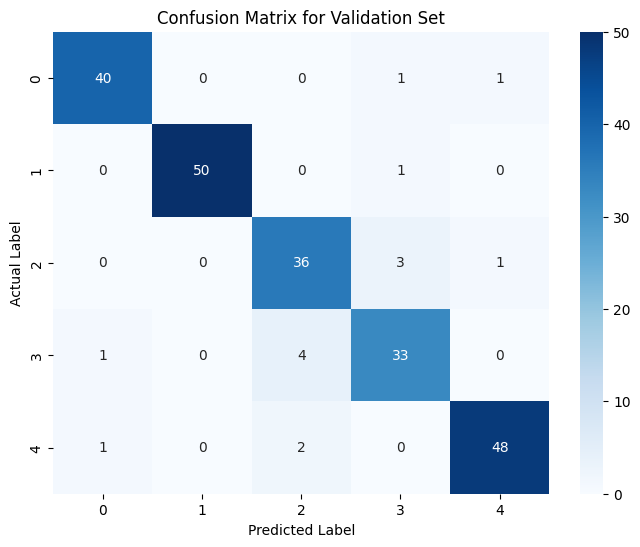

In [ ]:
# Plot Confusion Matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(df_val['Label'], df_val['Predicted_Label'])

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df_val['Label']), yticklabels=np.unique(df_val['Label']))

# Add labels and titles
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Hyperparameter Testing

In [ ]:
# Changing Epoch Values
results = []
epoch_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

for epochs in epoch_values:
  print("Epoch Value: ", epochs)
  model = Word2Vec([tokenized_sentence for sentence_list in df_train['Tokenised_Text'] for tokenized_sentence in sentence_list], vector_size=100, window=5, min_count=1, workers=4, epochs=epochs, sg=1)

  df_train['Sentence_Vector'] = df_train['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))
  df_val['Sentence_Vector'] = df_val['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))
  train_vectors = np.vstack(df_train['Sentence_Vector'].values)
  train_labels = df_train['Label'].values

  df_val['Predicted_Label'] = df_val['Sentence_Vector'].apply(lambda vec: classify_sentence(vec, train_vectors, train_labels))
  # Detailed classification report (precision, recall, F1-score)
  print(classification_report(df_val['Label'], df_val['Predicted_Label'], digits = 4))
  print()

  # Calculate and store performance metrics
  report = classification_report(df_val['Label'], df_val['Predicted_Label'], output_dict=True)
  results.append({
      'epochs': epochs,
      'precision': report['weighted avg']['precision'],
      'recall': report['weighted avg']['recall'],
      'f1-score': report['weighted avg']['f1-score']
  })

df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
plt.plot(df_results['epochs'], df_results['f1-score'], marker='o')
plt.title('F1-Score vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('F1-Score')
plt.ylim(0.8, 1)
plt.grid()
plt.show()

Epoch Value:  10
              precision    recall  f1-score   support

           0     0.9762    0.9762    0.9762        42
           1     0.9804    0.9804    0.9804        51
           2     0.8780    0.9000    0.8889        40
           3     0.8750    0.9211    0.8974        38
           4     0.9792    0.9216    0.9495        51

    accuracy                         0.9414       222
   macro avg     0.9378    0.9398    0.9385       222
weighted avg     0.9428    0.9414    0.9418       222


Epoch Value:  20
              precision    recall  f1-score   support

           0     0.9524    0.9524    0.9524        42
           1     0.9808    1.0000    0.9903        51
           2     0.8837    0.9500    0.9157        40
           3     0.9167    0.8684    0.8919        38
           4     0.9592    0.9216    0.9400        51

    accuracy                         0.9414       222
   macro avg     0.9385    0.9385    0.9380       222
weighted avg     0.9420    0.9414    0.941

Choose 30 Epochs

In [ ]:
# Changing Learning Rate
results = []
lr_values = [0.1, 0.09, 0.08, 0.07, 0.06, 0.050, 0.040, 0.030, 0.020, 0.010]

for lr in lr_values:
    print("Learning Rate Value: ", lr)
    model = Word2Vec(
        [tokenized_sentence for sentence_list in df_train['Tokenised_Text'] for tokenized_sentence in sentence_list],
        vector_size=100,  # Set your desired vector size
        window=5,
        min_count=1,
        workers=4,
        epochs=30,
        alpha=lr  # Use the variable `lr` for learning rate
    )

    df_train['Sentence_Vector'] = df_train['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))
    df_val['Sentence_Vector'] = df_val['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))

    train_vectors = np.vstack(df_train['Sentence_Vector'].values)
    train_labels = df_train['Label'].values

    df_val['Predicted_Label'] = df_val['Sentence_Vector'].apply(lambda vec: classify_sentence(vec, train_vectors, train_labels))

    # Detailed classification report (precision, recall, F1-score)
    print(classification_report(df_val['Label'], df_val['Predicted_Label'], digits = 4))
    print()

    # Calculate and store performance metrics
    report = classification_report(df_val['Label'], df_val['Predicted_Label'], output_dict=True)
    results.append({
        'learning_rate': lr,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    })

Learning Rate Value:  0.1
              precision    recall  f1-score   support

           0     0.9535    0.9762    0.9647        42
           1     1.0000    1.0000    1.0000        51
           2     0.9070    0.9750    0.9398        40
           3     0.9459    0.9211    0.9333        38
           4     1.0000    0.9412    0.9697        51

    accuracy                         0.9640       222
   macro avg     0.9613    0.9627    0.9615       222
weighted avg     0.9652    0.9640    0.9641       222


Learning Rate Value:  0.09
              precision    recall  f1-score   support

           0     0.9535    0.9762    0.9647        42
           1     1.0000    1.0000    1.0000        51
           2     0.8837    0.9500    0.9157        40
           3     0.9459    0.9211    0.9333        38
           4     1.0000    0.9412    0.9697        51

    accuracy                         0.9595       222
   macro avg     0.9566    0.9577    0.9567       222
weighted avg     0.9610

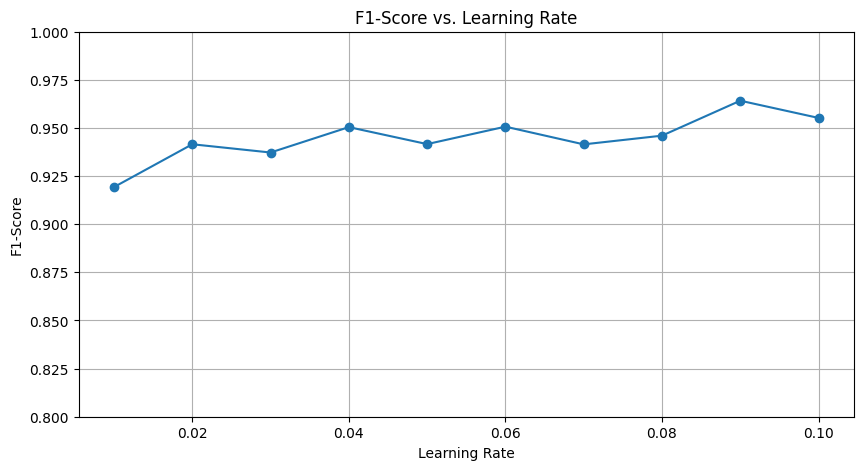

In [ ]:
df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
plt.plot(df_results['learning_rate'], df_results['f1-score'], marker='o')
plt.title('F1-Score vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('F1-Score')
plt.ylim(0.8,1)
plt.grid()
#plt.xscale('log')  # Use a log scale for better visualization
plt.show()

In [ ]:
# Changing Vector Sizes
results = []
vector_sizes = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

for vector in vector_sizes:
    print("Vector Size Value: ", vector)
    model = Word2Vec(
        [tokenized_sentence for sentence_list in df_train['Tokenised_Text'] for tokenized_sentence in sentence_list],
        vector_size=vector,  # Use the variable `vector` here
        window=5,
        min_count=1,
        workers=4,
        epochs=30,
        sg = 1
    )

    df_train['Sentence_Vector'] = df_train['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))
    df_val['Sentence_Vector'] = df_val['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))

    train_vectors = np.vstack(df_train['Sentence_Vector'].values)
    train_labels = df_train['Label'].values

    df_val['Predicted_Label'] = df_val['Sentence_Vector'].apply(lambda vec: classify_sentence(vec, train_vectors, train_labels))

    # Detailed classification report (precision, recall, F1-score)
    print(classification_report(df_val['Label'], df_val['Predicted_Label'], digits=4))
    print()

    # Calculate and store performance metrics
    report = classification_report(df_val['Label'], df_val['Predicted_Label'], output_dict=True)
    results.append({
        'vector': vector,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    })

Vector Size Value:  25
              precision    recall  f1-score   support

           0     0.9286    0.9286    0.9286        42
           1     0.9615    0.9804    0.9709        51
           2     0.8372    0.9000    0.8675        40
           3     0.8919    0.8684    0.8800        38
           4     0.9583    0.9020    0.9293        51

    accuracy                         0.9189       222
   macro avg     0.9155    0.9159    0.9152       222
weighted avg     0.9202    0.9189    0.9191       222


Vector Size Value:  50
              precision    recall  f1-score   support

           0     0.9318    0.9762    0.9535        42
           1     0.9804    0.9804    0.9804        51
           2     0.9000    0.9000    0.9000        40
           3     0.8947    0.8947    0.8947        38
           4     0.9796    0.9412    0.9600        51

    accuracy                         0.9414       222
   macro avg     0.9373    0.9385    0.9377       222
weighted avg     0.9419    0.9

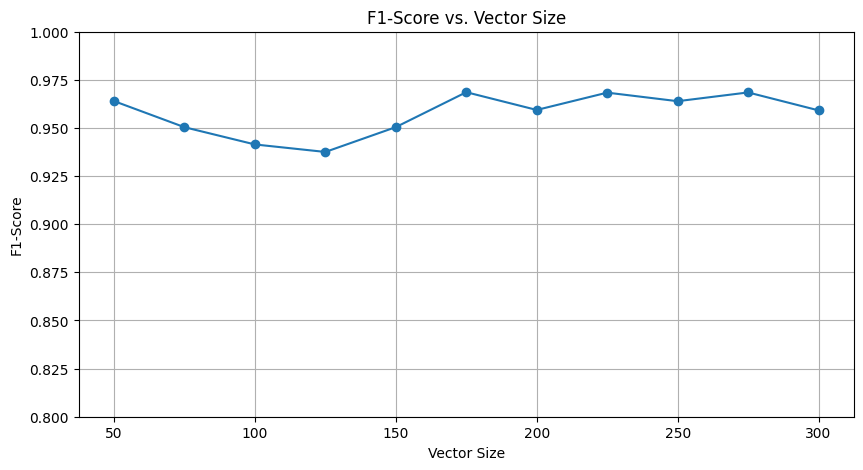

In [ ]:
df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
plt.plot(df_results['vector'], df_results['f1-score'], marker='o')
plt.title('F1-Score vs. Vector Size')
plt.xlabel('Vector Size')
plt.ylabel('F1-Score')
plt.ylim(0.8, 1)
plt.grid()
plt.show()

In [19]:
# Assuming you've identified the best hyperparameters, compare between before fine-tuning and after fine-tuning
best_vector_size = 100
best_epoch_value = 90


# Function to evaluate model and return performance metrics
def evaluate_model(model, df_train, df_val):
    df_train['Sentence_Vector'] = df_train['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))
    df_val['Sentence_Vector'] = df_val['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model, [word for sentence in sentences for word in sentence]))

    train_vectors = np.vstack(df_train['Sentence_Vector'].values)
    train_labels = df_train['Label'].values

    df_val['Predicted_Label'] = df_val['Sentence_Vector'].apply(lambda vec: classify_sentence(vec, train_vectors, train_labels))

    report = classification_report(df_val['Label'
    ], df_val['Predicted_Label'], output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score'],
        'support': report['weighted avg']['support']
    }

# Original model (before hyperparameter tuning)
model_before = Word2Vec([tokenized_sentence for sentence_list in df_train['Tokenised_Text'] for tokenized_sentence in sentence_list], vector_size=100, window=5, min_count=1, workers=4, epochs=5, sg=1)
metrics_before = evaluate_model(model_before, df_train, df_val)

# Fine-tuned model (after hyperparameter tuning)
model_after = Word2Vec([tokenized_sentence for sentence_list in df_train['Tokenised_Text'] for tokenized_sentence in sentence_list],
                       vector_size=100,
                       sg=1,
                       window=5,
                       min_count=1,
                       workers=4,
                       epochs=best_epoch_value)
metrics_after = evaluate_model(model_after, df_train, df_val)

# Print the metrics for comparison
print("Performance Metrics Before Hyperparameter Tuning:")
print(f"Accuracy: {metrics_before['accuracy']:.4f}")
print(f"Precision: {metrics_before['precision']:.4f}")
print(f"Recall: {metrics_before['recall']:.4f}")
print(f"F1-Score: {metrics_before['f1-score']:.4f}")

print("\nPerformance Metrics After Hyperparameter Tuning:")
print(f"Accuracy: {metrics_after['accuracy']:.4f}")
print(f"Precision: {metrics_after['precision']:.4f}")
print(f"Recall: {metrics_after['recall']:.4f}")
print(f"F1-Score: {metrics_after['f1-score']:.4f}")

Performance Metrics Before Hyperparameter Tuning:
Accuracy: 0.9414
Precision: 0.9420
Recall: 0.9414
F1-Score: 0.9417

Performance Metrics After Hyperparameter Tuning:
Accuracy: 0.9505
Precision: 0.9527
Recall: 0.9505
F1-Score: 0.9501


# Test

In [ ]:
df_test['Sentence_Vector'] = df_test['Tokenised_Text'].apply(lambda sentences: get_sentence_vector(model_after, [word for sentence in sentences for word in sentence]))

train_vectors = np.vstack(df_train['Sentence_Vector'].values)
train_labels = df_train['Label'].values

# Classify Test Set
df_test['Predicted_Label'] = df_test['Sentence_Vector'].apply(lambda vec: classify_sentence(vec, train_vectors, train_labels))

test_accuracy = accuracy_score(df_test['Label'], df_test['Predicted_Label'])
print(f'Test Accuracy: {test_accuracy}')

# Confusion matrix and classification report
conf_matrix_test = confusion_matrix(df_test['Label'], df_test['Predicted_Label'])
print(f'Confusion Matrix (Test):\n{conf_matrix_test}')

print(classification_report(df_test['Label'], df_test['Predicted_Label'], digits = 4))


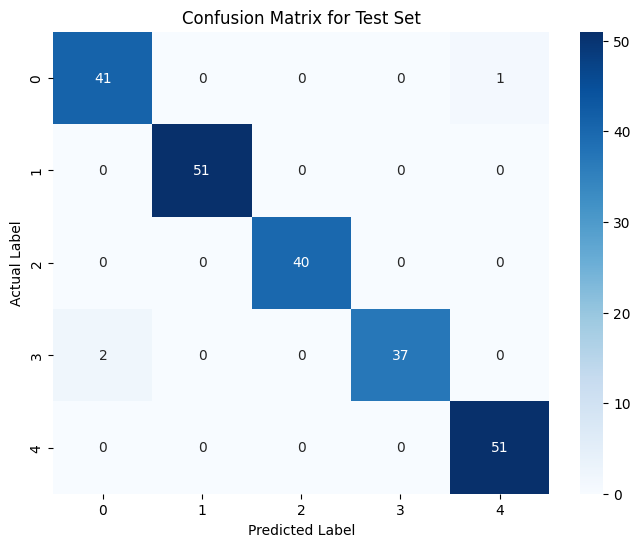

In [25]:
# Plot Confusion Matrix
# Calculate the confusion matrix
conf_matrix_test = confusion_matrix(df_test['Label'], df_test['Predicted_Label'])

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df_test['Label']), yticklabels=np.unique(df_test['Label']))

# Add labels and titles
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Test Set')
plt.show()